In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense,Dropout,MaxPooling2D,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
# Input data files are available in the "/kaggle/input/110-1-ntut-dl-app-hw1/" directory.
DATA_DIR = '/kaggle/input/ntutemnist/'
TRAIN_DATA_FILE = DATA_DIR + 'emnist-byclass-train.npz'
TEST_DATA_FILE = DATA_DIR + 'emnist-byclass-test.npz'

In [4]:
# Load training data & test data
data = np.load(TRAIN_DATA_FILE)
train_labels = data['training_labels']
train_images = data['training_images']


test_images = np.load(TEST_DATA_FILE)['testing_images']

print(train_labels.shape)
print(train_images.shape)
print(test_images.shape)

(697932, 1)
(697932, 28, 28, 1)
(116322, 28, 28, 1)


Let's see what type of images we have got.

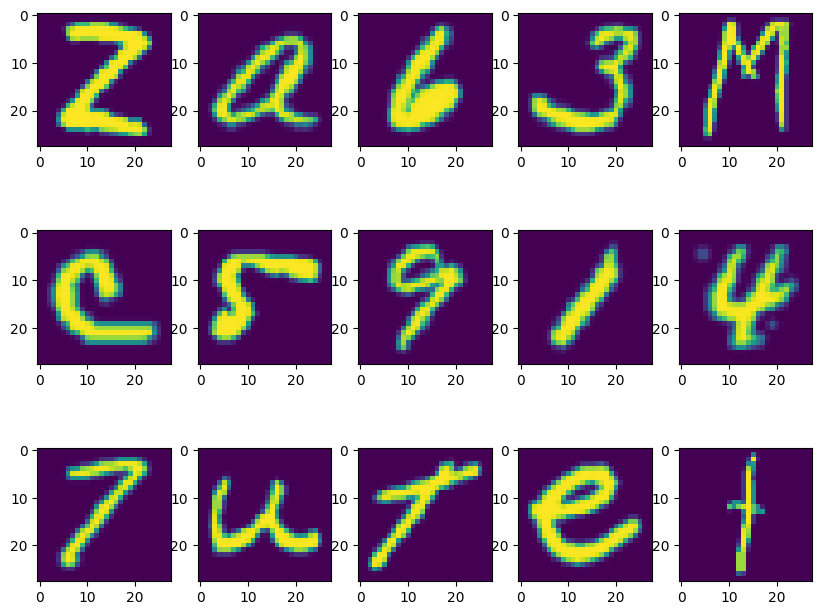

In [5]:
fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(train_images[i].reshape([28,28]))

Preprocesssing

1. Normalisation and reshaping of data


Before feeding in the data to the model we will normalise and reshape the data given to us. This will decrease the complexity of the models and make the model work efficiently as less complex numbers will be there to process.


In [6]:
# Normalise and reshape data
trn_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
trn_images = trn_images.astype('float32') / 255
trn_images.shape

(697932, 28, 28, 1)

In [7]:
tst_images = test_images.reshape((test_images.shape[0], 28,  28, 1))
tst_images = tst_images.astype('float32') / 255
tst_images.shape

(116322, 28, 28, 1)

In [8]:
# Transform labels
number_of_classes = 62
trn_labels = tf.keras.utils.to_categorical(train_labels, number_of_classes)
trn_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Lets create a CNN for the classification of these random images.

In [9]:
train_x, test_x, train_y, test_y = train_test_split(trn_images, trn_labels, test_size=0.1,random_state = 42) # test_size=0.15 or 0.2

In [10]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

In [11]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

Adding Callback API's to save best weights and change lr

In [12]:
MCP = ModelCheckpoint('Best_points.h5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
ES = EarlyStopping(monitor='val_accuracy', min_delta=0, verbose=0, restore_best_weights = True, patience=5, mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)

In [13]:
history = model.fit(train_x, train_y, epochs=10, validation_data=(test_x,test_y), callbacks=[ES,RLP]) # epochs=2 # callbacks=[MCP,ES,RLP]

Epoch 1/10
19630/19630 [==============================] - 531s 27ms/step - loss: 0.8225 - accuracy: 0.7521 - val_loss: 0.5576 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 2/10
19630/19630 [==============================] - 527s 27ms/step - loss: 0.5548 - accuracy: 0.8193 - val_loss: 0.5356 - val_accuracy: 0.8198 - lr: 0.0010
Epoch 3/10
19630/19630 [==============================] - 515s 26ms/step - loss: 0.5420 - accuracy: 0.8237 - val_loss: 0.5351 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 4/10
19630/19630 [==============================] - 513s 26ms/step - loss: 0.5401 - accuracy: 0.8247 - val_loss: 0.6230 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 5/10
19630/19630 [==============================] - 514s 26ms/step - loss: 0.5442 - accuracy: 0.8243 - val_loss: 0.6032 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 6/10
19630/19630 [==============================] - 504s 26ms/step - loss: 0.5472 - accuracy: 0.8249 - val_loss: 0.6698 - val_accuracy: 0.7966 - lr: 0.0010
Epoch 7/10
19630/19630 [====

Let's plot Accuracy vs Val_Accuracy to further evaluation..

Text(0, 0.5, 'Accuray')

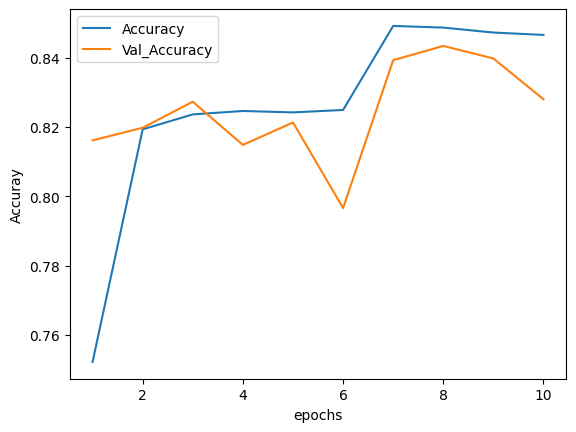

In [14]:
q = len(history.history['accuracy'])
plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')

In [15]:
results = model.predict(tst_images).argmax(axis=-1)
results 

3636/3636 [==============================] - 24s 6ms/step


array([ 1, 36,  0, ..., 55, 28, 24])

In [16]:
# Print results in CSV format and upload to Kaggle
with open('pred_results.csv', 'w') as f:
    f.write('Id,Category\n')
    for i in range(len(results)):
        f.write(str(i) + ',' + str(results[i]) + '\n')

In [17]:
# Download your results!
from IPython.display import FileLink
FileLink('pred_results.csv')

/kaggle/working/pred_results.csv